# 1.载入数据

In [1]:
import os, warnings, time
import numpy as np
import pandas as pd
import pyreadstat
import matplotlib.pyplot as plt
from scipy import stats
import re, unicodedata
from sklearn.utils.multiclass import type_of_target
from sklearn.feature_selection import chi2, f_classif
from scipy.stats import pearsonr, f_oneway

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from matplotlib import rcParams

import shap
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from matplotlib import rcParams
import re
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings("ignore")
RANDOM_STATE = 1234

In [ ]:
# 加载数据
# os.chdir("C:/Users/liuxi/Desktop/T12")

df_all = pd.read_spss("01_input/data_T12_1024_xingyu.sav")
df_all["residence"] = df_all["residence"].replace({".": np.nan, "": np.nan, " ": np.nan})

# 2.变量预处理

In [4]:
# 父母最高教育水平
# 父亲教育程度重编码
def recode_edu_fa(x):
    if pd.isna(x):
        return np.nan
    elif x in [1, 2, 3]:
        return 1  # 初中及以下
    elif x in [4, 5]:
        return 2  # 高中/中专
    elif x == 6:
        return 3  # 专科
    elif x == 7:
        return 4  # 本科
    elif x == 8:
        return 5  # 研究生及以上
    elif x == 9:
        return np.nan  # 不清楚设为NA
    else:
        return np.nan

# 母亲教育程度重编码
def recode_edu_ma(x):
    if pd.isna(x):
        return np.nan
    elif x in [1, 2, 3]:
        return 1  # 初中及以下
    elif x in [4, 5]:
        return 2  # 高中/中专
    elif x == 6:
        return 3  # 专科
    elif x == 7:
        return 4  # 本科
    elif x == 8:
        return 5  # 研究生及以上
    elif x == 9:
        return np.nan  # 不清楚设为NA
    else:
        return np.nan
df_all['edu_fa_cat'] = df_all['edu_fa'].apply(recode_edu_fa)
df_all['edu_ma_cat'] = df_all['edu_ma'].apply(recode_edu_ma)
# 取父母最高学历
df_all['edu_pa'] = df_all[['edu_fa_cat', 'edu_ma_cat']].max(axis=1)

In [5]:
# 父母婚姻状态:转换为0-1变量
df_all['marrige_par_bin'] = df_all['marrige_par_T1'].apply(lambda x: 0 if x == 1 else 1)
print(df_all['marrige_par_bin'].value_counts())

0    977
1    117
Name: marrige_par_bin, dtype: int64


In [6]:
# 将 gender 与 residence 转为 0/1
# gender: 女=1, 男=0
df_all["gender_T1"] = (df_all["gender_T1"] == 1).astype(int)
# residence: 城市=1, 乡村=0
df_all["residence"] = (df_all["residence"] == 1).astype(int)

In [7]:
# BMI
df_all["height_T1"] = pd.to_numeric(df_all["height_T1"], errors="coerce")
df_all["weight_T1"] = pd.to_numeric(df_all["weight_T1"], errors="coerce")
# 查看
print(df_all[["height_T1", "weight_T1"]].describe())

         height_T1    weight_T1
count  1094.000000  1092.000000
mean    168.752870    62.338919
std      12.272889    15.878014
min       0.000000    36.000000
25%     163.000000    52.000000
50%     168.000000    59.000000
75%     175.000000    69.000000
max     196.000000   165.000000


In [8]:
# 找出异常
abnormal_height = df_all[(df_all["height_T1"] < 100) | (df_all["height_T1"] > 200)]
abnormal_weight = df_all[(df_all["weight_T1"] < 30) | (df_all["weight_T1"] > 150)]
abnormal_cases = df_all.loc[
    (df_all["height_T1"] < 100) | (df_all["height_T1"] > 200) |
    (df_all["weight_T1"] < 30)  | (df_all["weight_T1"] > 150),
    ["height_T1", "weight_T1"]
]
print(abnormal_cases)

     height_T1  weight_T1
35       10.00       58.0
58        0.00        NaN
261       1.54       60.0
483     180.00      165.0
508     173.00      165.0
982     192.00      156.0


In [9]:
# 计算 BMI
df_all["BMI_T1"] = df_all["weight_T1"] / (df_all["height_T1"] / 100) ** 2
print(df_all["BMI_T1"].describe())

count      1092.000000
mean        258.571456
std        7657.123083
min          13.957759
25%          18.906901
50%          20.761246
75%          23.140496
max      252993.759487
Name: BMI_T1, dtype: float64


In [10]:
# 查BMI异常值
abnormal_bmi = df_all[(df_all["BMI_T1"] < 10) | (df_all["BMI_T1"] > 50)]
print(abnormal_bmi[["height_T1", "weight_T1", "BMI_T1"]])

     height_T1  weight_T1         BMI_T1
35       10.00       58.0    5800.000000
261       1.54       60.0  252993.759487
483     180.00      165.0      50.925926
508     173.00      165.0      55.130475


In [11]:
# 删除BMI异常值
df_all = df_all[~df_all.index.isin(abnormal_bmi.index)]

In [12]:
# 将BMI设置为类别变量
def bmi_category(x):
    if pd.isna(x):
        return np.nan
    elif x < 18.5:
        return "1"
    elif 18.5 <= x < 25:
        return "2"
    elif 25 <= x < 30:
        return "3"
    else:
        return "4"
df_all["BMI_T1_cat"] = df_all["BMI_T1"].apply(bmi_category)
df_all["BMI_T1_cat"] = df_all["BMI_T1_cat"].astype("category")
# 查看分布
print(df_all["BMI_T1_cat"].value_counts(dropna=False))

2      693
1      236
3      117
4       42
NaN      2
Name: BMI_T1_cat, dtype: int64


In [13]:
# 查看数据维度
print('Number of rows are {} | Number of column are {}'\
.format(df_all.shape[0], df_all.shape[1]))

Number of rows are 1090 | Number of column are 449


In [14]:
# 睡眠时长（答案迥异，所以人肉在原数据集中改了一遍）
# 将睡眠时长设置为类别变量：<5h记为0分，5-6h记为1分，6-7h记为2分，>7h记为4分
df_all["sleep_dura_T1"] = pd.to_numeric(df_all["sleep_dura_T1"], errors="coerce")
def sleep_score_reverse(x):
    if pd.isna(x):
        return np.nan
    elif x < 5:
        return 0
    elif 5 <= x < 6:
        return 1
    elif 6 <= x <= 7:
        return 2
    elif x > 7:
        return 3
    else:
        return np.nan
df_all["sleep_dura_T1_cat"] = df_all["sleep_dura_T1"].apply(sleep_score_reverse)

In [15]:
# IPAQ处理：生成三个二元变量
cols_to_binary = ["IPAQ_T1_1", "IPAQ_T1_3", "IPAQ_T1_5"]
for col in cols_to_binary:
    new_col = col + "_bin"
    df_all[new_col] = df_all[col].map({1: 1, 2: 0}) # 1表示有活动，0表示无活动
print(df_all[["IPAQ_T1_1_bin", "IPAQ_T1_3_bin", "IPAQ_T1_5_bin"]].head())

   IPAQ_T1_1_bin  IPAQ_T1_3_bin  IPAQ_T1_5_bin
0              1              1              0
1              0              1              1
2              0              0              1
3              1              1              1
4              0              0              1


In [16]:
# income处理，8=其他，9=我不知道
# RF无法自动处理Missing,添加指示变量
df_all['income'] = df_all['income'].replace([8, 9], np.nan)

In [17]:
# 描述性统计
pd.set_option('display.float_format', '{:.2f}'.format) #保留2位小数
df_all.describe()

,age_T1,age_T2,gender_T1,gender_T2,school_T2,major_T2,pocket_mon_T2,nationality_T2,height_T1,weight_T1,...,online_dis_y1,edu_fa_cat,edu_ma_cat,edu_pa,marrige_par_bin,BMI_T1,sleep_dura_T1_cat,IPAQ_T1_1_bin,IPAQ_T1_3_bin,IPAQ_T1_5_bin
count,1090.00,1090.00,1090.00,1090.00,747.00,343.00,1090.00,747.00,1090.00,1088.00,...,1090.00,1024.00,1029.00,1038.00,1090.00,1088.00,1077.00,1090.00,1090.00,1090.00
mean,19.32,19.94,0.61,1.39,4.83,9.20,4.77,1.60,169.04,62.16,...,0.07,2.81,2.65,2.99,0.11,21.56,2.44,0.67,0.58,0.79
std,0.87,0.95,0.49,0.49,3.24,4.97,1.83,1.90,10.11,15.28,...,0.48,1.43,1.36,1.42,0.31,4.28,0.58,0.47,0.49,0.41
min,17.00,18.00,0.00,1.00,1.00,2.00,1.00,1.00,0.00,36.00,...,0.00,1.00,1.00,1.00,0.00,13.96,0.00,0.00,0.00,0.00
25%,19.00,19.00,0.00,1.00,3.00,2.00,4.00,1.00,163.00,52.00,...,0.00,1.00,1.00,2.00,0.00,18.91,2.00,0.00,0.00,1.00
50%,19.00,20.00,1.00,1.00,4.00,12.00,5.00,1.00,168.00,59.00,...,0.00,3.00,3.00,3.00,0.00,20.74,2.00,1.00,1.00,1.00
75%,20.00,20.00,1.00,2.00,6.00,14.00,6.00,1.00,175.00,69.00,...,0.00,4.00,4.00,4.00,0.00,23.10,3.00,1.00,1.00,1.00
max,24.00,25.00,1.00,2.00,15.00,14.00,10.00,9.00,196.00,156.00,...,4.00,5.00,5.00,5.00,1.00,48.98,3.00,1.00,1.00,1.00


In [18]:
# 查看数据类型
df_all.dtypes

ID                     object
age_T1                float64
age_T2                float64
gender_T1               int32
gender_T2             float64
                       ...   
BMI_T1_cat           category
sleep_dura_T1_cat     float64
IPAQ_T1_1_bin           int64
IPAQ_T1_3_bin           int64
IPAQ_T1_5_bin           int64
Length: 453, dtype: object

In [19]:
# 数据类型处理
df_all["sss_now"] = pd.to_numeric(df_all["sss_now"], errors="coerce")

In [20]:
# 缺失值
missing_info = df_all.isna().sum().to_frame("缺失数")
missing_info["缺失比例(%)"] = (missing_info["缺失数"] / len(df_all)) * 100
missing_info = missing_info.sort_values("缺失比例(%)", ascending=False)
print(missing_info)

                 缺失数  缺失比例(%)
nat_dis_T1_3     918    84.22
online_dis_T1_4  918    84.22
nat_dis_T1_1     918    84.22
nat_dis_T1_2     918    84.22
nat_dis_T1_4     918    84.22
...              ...      ...
loneliness_T1_1    0     0.00
loneliness_T2_6    0     0.00
loneliness_T2_5    0     0.00
loneliness_T2_4    0     0.00
IPAQ_T1_5_bin      0     0.00

[453 rows x 2 columns]


In [21]:
# 删除睡眠时长缺失
df_all = df_all.dropna(subset=["sleep_dura_T1_cat"]).reset_index(drop=True)

In [22]:
# 查看数据维度
print('Number of rows are {} | Number of column are {}'\
.format(df_all.shape[0], df_all.shape[1]))

Number of rows are 1077 | Number of column are 453


偏度(Skewness): 0.9360
峰度(Kurtosis): 1.0223


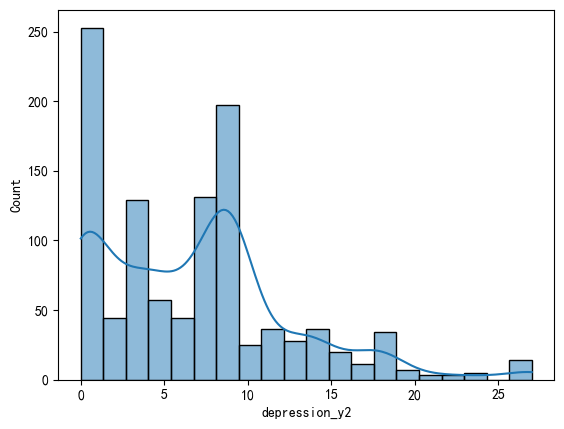

In [23]:
# 检查outcome的偏态情况
import seaborn as sns

y = pd.to_numeric(df_all["depression_y2"], errors="coerce")
sns.histplot(y, kde=True)
# 计算偏度(Skewness)
skewness = stats.skew(y)
print(f'偏度(Skewness): {skewness:.4f}')

# 计算峰度(Kurtosis)
kurtosis = stats.kurtosis(y)
print(f'峰度(Kurtosis): {kurtosis:.4f}')

In [24]:
model_vars = [
    # predictor
    # Physiological and health: 躯体健康、BMI、睡眠（时长、质量、失眠）
    "somatic_y1", "height_T1", "weight_T1","sleep_dura_T1","sleep_quali_T1", "insomnia_y1",
    # Psychological：生活满意度、SES思维模式、压力感知、压力心态、Mental health history
    "life_satis_y1", "ms_ses_y1","ms_stress_y1","depression_y1","anxiety_y1","per_stress_y1",
    # Predictors of response to trauma
    "ace",
    # Relational 
   "loneliness_y1","support_y1",
    # Sociodemographic ⚠️删掉grade保留年龄
    "gender_T1", "age_T1", "residence", "income", "pocket_mon_T1", "sss_now", "income_ineqCity_y1", "marrige_par_T1", "edu_ma","edu_fa",
    # Lifestyle
    # 饮食
    "eat_unctl_y1","eat_emot_y1","food_sweetdrink_T1","food_takeout_T1",
    # 运动
    "IPAQ_T1_1", "IPAQ_T1_3", "IPAQ_T1_5",
    # 屏幕时间
    "screenT_weekday_T1","screenT_weekend_T1",
    # 社交媒体
    "psmu_y1", "media_BadMood_T1", "media_GoodMood_T1",
    # Factors related to Higher Education
     "edu_self",
    # outcome
    # "depression_y2"
    "insomnia_y2"
]
df_model = df_all[model_vars].copy()

# 导出df_all以供R中使用
df_all.to_csv("D:/Research-SJTUH/UniversityData/UniData/INS_prediction/Input/df_all_ins.csv", index=False, encoding='utf-8-sig')
df_model.to_csv("D:/Research-SJTUH/UniversityData/UniData/INS_prediction/Input/df_model_ins.csv", index=False, encoding='utf-8-sig')